In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import librosa

from src.datamodules import AASISTDataset, MFCCDataset, FixMatchDataset

from IPython.display import Audio

/home/anaconda3/envs/joono/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")
unlabeled_df = pd.read_csv("../dataset/unlabeled_data.csv")

In [3]:
train_dset = FixMatchDataset(df=train_df, unlabeled_df=unlabeled_df, train_mode=True, model_name="facebook/wav2vec2-base")
test_dset = FixMatchDataset(df=test_df, train_mode=False, model_name="facebook/wav2vec2-base")
unlabeled_dset  = FixMatchDataset(df=unlabeled_df, train_mode=False, model_name="facebook/wav2vec2-base")

/home/anaconda3/envs/joono/lib/python3.10/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [4]:
# train_dset = AASISTDataset(df=train_df, train_mode=True)
# test_dset  = AASISTDataset(df=test_df, train_mode=False)
# train_dset = MFCCDataset(df=train_df, train_mode=True, sr=16000, n_mfcc=20, n_classes=2)
# test_dset  = MFCCDataset(df=test_df, train_mode=False, sr=16000, n_mfcc=20, n_classes=2)
# unlabeled_dset  = MFCCDataset(df=unlabeled_df, train_mode=False, sr=16000, n_mfcc=20, n_classes=2)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assuming train_dset and test_dset are numpy arrays or similar data structures with MFCC data
# For example, train_dset[2][0] contains the MFCC data for a specific sample

train_sample_indices = np.random.randint(0, len(train_dset), size=1000)
test_sample_indices  = np.random.randint(0, len(test_dset), size=1000)
unlabeled_sample_indices = np.random.randint(0, len(unlabeled_dset), size=1000)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
audio, weak_audio, strong_audio, _ = train_dset[9495]

In [5]:
Audio(np.array(audio), rate=16000)

NameError: name 'audio' is not defined

In [16]:
target_cnts = [0, 0, 0, 0]
for i in tqdm(train_sample_indices):
    _, _, _, target = train_dset[i]
    target_cnts[target] += 1

100%|██████████| 1000/1000 [00:22<00:00, 44.93it/s]


In [17]:
target_cnts

[244, 250, 271, 235]

In [ ]:
def get_mfcc(audio):
    mfcc = librosa.feature.mfcc(y=np.array(audio), sr=16000, n_mfcc=20)
    return np.mean(mfcc.T, axis=0)

In [ ]:
mfcc_data_train = np.array([get_mfcc(train_dset[i][0]) for i in tqdm(train_sample_indices)])
mfcc_data_test = np.array([get_mfcc(test_dset[i]) for i in tqdm(test_sample_indices)])
mfcc_data_unlabeled = np.array([get_mfcc(unlabeled_dset[i]) for i in tqdm(unlabeled_sample_indices)])

# Calculate summary statistics for training data
mean_mfcc_train = np.mean(mfcc_data_train, axis=0)
std_mfcc_train = np.std(mfcc_data_train, axis=0)

# Calculate summary statistics for test data
mean_mfcc_test = np.mean(mfcc_data_test, axis=0)
std_mfcc_test = np.std(mfcc_data_test, axis=0)

# Calculate summary statistics for weak aug unlabeled data
mean_mfcc_unlabeled = np.mean(mfcc_data_unlabeled, axis=0)
std_mfcc_unlabeled = np.std(mfcc_data_unlabeled, axis=0)

# Plot the mean MFCC with error bars representing the standard deviation for both train and test sets
plt.figure(figsize=(12, 8))

# Plot for training data
plt.errorbar(np.arange(len(mean_mfcc_train)), mean_mfcc_train, yerr=std_mfcc_train, fmt='-o', capsize=5, label='Train Set')

# Plot for test data
plt.errorbar(np.arange(len(mean_mfcc_test)), mean_mfcc_test, yerr=std_mfcc_test, fmt='-o', capsize=5, label='Test Set')

# Plot for test data
plt.errorbar(np.arange(len(mean_mfcc_unlabeled)), mean_mfcc_unlabeled, yerr=std_mfcc_unlabeled, fmt='-o', capsize=5, label='Unlabeled Set')

plt.title('Mean MFCC with Standard Deviation for Train and Test Sets and Unlabeled')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Plot the differences between the means of train, test, and extra sets
plt.figure(figsize=(15, 8))

# Difference between train and test sets
mean_diff_train_test = mean_mfcc_train - mean_mfcc_test
plt.plot(mean_diff_train_test, label="train - test")

# Difference between train and extra sets
mean_diff_train_extra = mean_mfcc_train - mean_mfcc_unlabeled
plt.plot(mean_diff_train_extra, label="train - unlabeled")

# Difference between test and extra sets
mean_diff_test_extra = mean_mfcc_test - mean_mfcc_unlabeled
plt.plot(mean_diff_test_extra, label="test - unlabeled")

plt.title('Difference in Mean MFCC between Train, Test, and Extra Sets')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Difference in Amplitude')
plt.legend()
plt.show()

In [ ]:
# Randomly sample some MFCC data points
sample_indices = np.random.choice(len(mfcc_data_test), size=100, replace=False)
sample_mfcc_data = mfcc_data_test[sample_indices]

# Plot a heatmap of sampled MFCC data
plt.figure(figsize=(12, 8))
sns.heatmap(sample_mfcc_data.T, cmap='viridis', xticklabels=sample_indices, yticklabels=np.arange(sample_mfcc_data.shape[1]))
plt.title('Heatmap of Sampled MFCC Data')
plt.xlabel('Sample Index')
plt.ylabel('MFCC Coefficient Index')
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Define a function to plot MFCC for a given sample index
def plot_mfcc(sample_index):
    plt.figure(figsize=(10, 6))
    plt.bar(x=np.arange(mfcc_data_test.shape[1]), height=mfcc_data_test[sample_index])
    plt.title(f'MFCC for Sample Index {sample_index}')
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Amplitude')
    plt.ylim(-300, 300)
    plt.show()

# Create an interactive widget
sample_index_slider = widgets.IntSlider(value=0, min=0, max=len(mfcc_data_test)-1, step=1, description='Sample Index')

# Display the widget
widgets.interact(plot_mfcc, sample_index=sample_index_slider)


In [ ]:
Audio(labeled_audio, rate=16000)

In [ ]:
import torch

a = torch.rand((6, 4))
a

In [ ]:
b = torch.argmax(a, dim=1)
c, _ = torch.max(a, dim=1)
mask = c > 0.95

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

In [ ]:
loss = loss_fn(a, b)

In [ ]:
loss * mask

In [ ]:
torch.mean(loss * mask)

In [1]:
from transformers import AutoFeatureExtractor
import librosa

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")

In [9]:
audio, _ = librosa.load("/home/joono/joono/dataset/test/TEST_00000.ogg", sr=16000)
audio = librosa.util.normalize(audio)
inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = inputs["input_values"]

In [10]:
import matplotlib.pyplot as plt

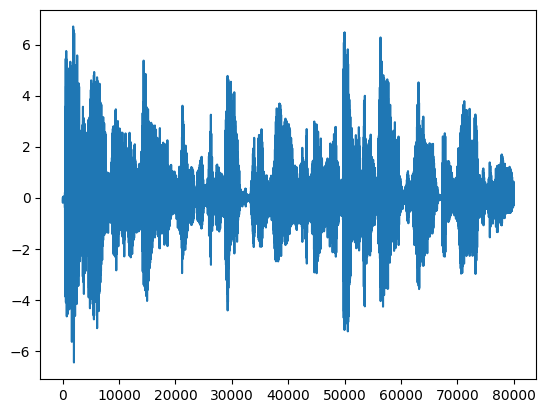

In [11]:
plt.plot(inputs.squeeze(0))

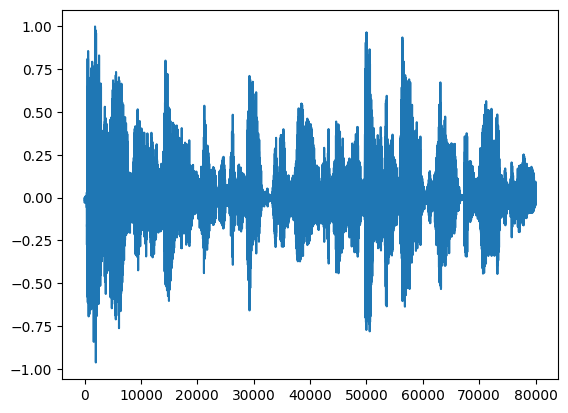

In [5]:
plt.plot(librosa.util.normalize(audio))